# Arima model example: seasonal series

This notebook describes the application of a Box-Jenkins approach to create an ARIMA model for a time series. The idea is to duplicate the procedure here described for other datasets.

In [1]:
%matplotlib inline
%reload_ext rpy2.ipython
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
from pathlib import Path
from sklearn import metrics, model_selection
from sklearn.model_selection import TimeSeriesSplit
from fbprophet import Prophet

from ts_arima.model_selection import select_ts_model
from ts_arima.model_selection.stats_tests import check_adfuller
from ts_arima.model_selection.error_metrics import error_measure

/home/ispmarin/lib/venvs/ts/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ispmarin/lib/venvs/ts/lib/python3.6/site-packages/rpy2/ipython/rmagic.py:73: UserWarning: The Python package 'pandas' is stronglyrecommended when using `rpy2.ipython`. Unfortunately it could not be loaded, but at least we found 'numpy'.
  "but at least we found 'numpy'.")))
/home/ispmarin/lib/venvs/ts/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [36]:
dataset_root = Path('../data')
dataset = 'passenger.csv'

data_path = dataset_root / dataset

df = pd.read_csv(data_path)
date_index = pd.date_range('1949-01', periods=len(df), freq='m')
df = df.set_index(date_index)
df.y = df.y.astype(float)

### First step: Run sequence plot
The run sequence plot is a standard plot of the time series sequence. 


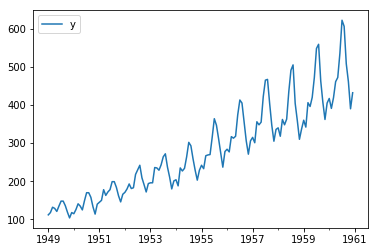

In [37]:
df.plot()

There is a variation on the data

### Second step: Run Autocorrelation plot

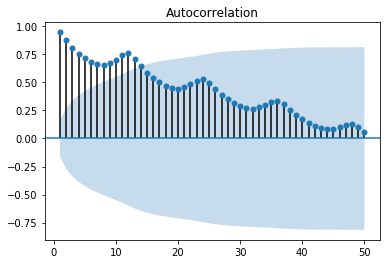

In [38]:
fig = sm.graphics.tsa.plot_acf(df, lags=50, zero=False)

Plot indicates that the series is stationary and with AR = 2.

### Series differentiation

The series needs to be diferentiated. Note that the log of the series is taken before the differentiation, to remove the trend.

In [39]:
check_adfuller(df.y)

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


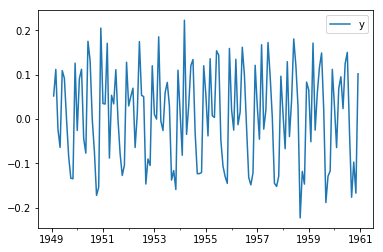

In [40]:
df_diff = df.apply(np.log).diff().dropna()
df_diff.plot()

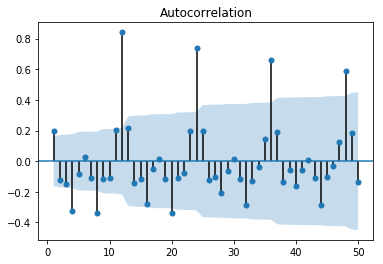

In [41]:
fig = sm.graphics.tsa.plot_acf(df_diff, zero=False, lags=50)

In [42]:
check_adfuller(df_diff.y)

ADF Statistic: -2.717131
p-value: 0.071121
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579


Now the Ad Fuller test has a better result, indicating that the series is more stationary. The autocorrelation plot indicates a seasonality of 12 and 24 periods, so we will take more differentiations with respect the seasonal periods, in this case, 12.

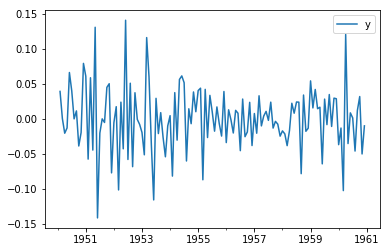

In [43]:
df_diff_s = df_diff.diff(12).dropna()
df_diff_s.plot()

It's important to note that this differencing is with respect to the seasonal pattern, so there is a MA(1) coefficient corresponding to the seasonal term.

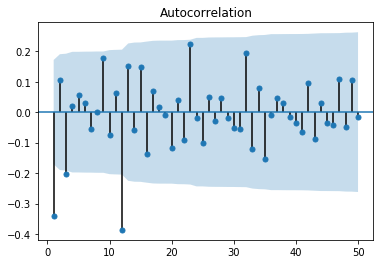

In [44]:
fig = sm.graphics.tsa.plot_acf(df_diff_s, zero=False, lags=50)

Now we can see that there are two values remaining outside the 95% confidence band. As this is the autocorrelation plot, we deduce that the model should be MA(1).

### Partial autocorrelation of differentiated series

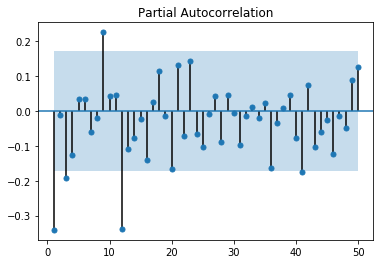

In [45]:
fig = sm.graphics.tsa.plot_pacf(df_diff_s, lags=50, zero=False)

There are still some values outside the band, mostly at 12.

## Model fit

Now, let's try to understand what's going on with all the parameters.

- `(0,1,1)` means that there is one order of differencing and one order of MA. 
- `(0,1,1,12)` means that there is one order of seasonal diferencing, one order of MA, and the period of seasonal differencing is 12. 

In [46]:
mdl_011_011_12 = sm.tsa.SARIMAX(np.log(df), order=(0,1,1), seasonal_order=(0,1,1,12)).fit()

In [47]:
mdl_011_011_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            dom, 29 abr 2018   AIC                           -483.393
Time:                                    22:20:09   BIC                           -474.484
Sample:                                01-31-1949   HQIC                          -479.773
                                     - 12-31-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4019      0.073     -5.503      0.000      -0.545      -0.259
ma.S.L12      -0.5567      0.096     -5.780      0.000      -0.745      -0.368
sigma2         0.0013      0.000      9.120      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       37.37   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.59   Prob(JB):                         0.39
Heteroskedasticity (H):               0.58   Skew:                             0.02
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prediction

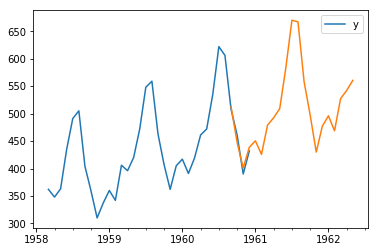

In [48]:
y_hat = np.exp(mdl_011_011_12.predict(start=140, end=160, typ='levels'))
ax = df.iloc[110:146].plot()
y_hat.plot(ax=ax)


### Error evaluation

In [49]:
df_train, df_test = select_ts_model.train_test_split_ts(df,0.3)

199.2060941754285


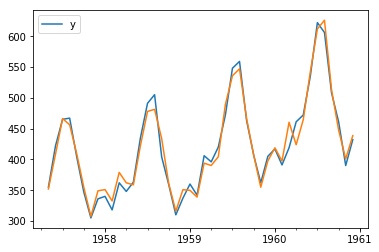

In [50]:
mdl_err = mdl_011_011_12
y_hat = np.exp(mdl_err.predict(start=df_test.index.min(), end=df_test.index.max(), typ='levels'))
print(metrics.mean_squared_error(df_test.y.values, y_hat.values))
ax = df_test.plot()
y_hat.plot(ax=ax)

In [91]:
def sarimax_011(df_train, df_test):
    mdl = sm.tsa.SARIMAX(df_train.y, order=(0,1,1), 
                         #seasonal_order=(0,1,1,12)
                        ).fit()
    return mdl.forecast(steps=len(df_test), typ='levels')

In [93]:
df_result = select_ts_model.cross_validate_ts(df, sarimax_011)

In [106]:
df_result.groupby('cutoff').apply(
        error_measure
)

cutoff
1952-01-31    (3404.6123359270387, 48.230837221683686)
1955-01-31     (11678.051771178392, 90.85816482180002)
1958-01-31     (11543.551187573843, 81.10417783546542)
dtype: object

# Prophet

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ispmarin/lib/venvs/ts/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


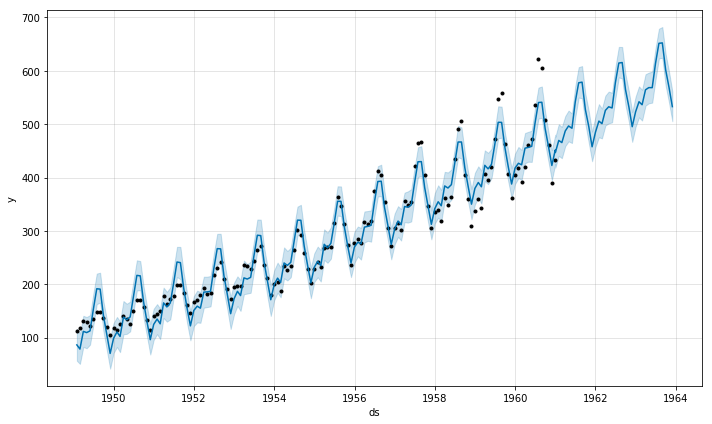

In [55]:
#df_ln = np.log(df)
#df_ln['ds'] = df_ln.index
df['ds'] = df.index

mdl_prophet = Prophet()
#mdl_prophet.add_seasonality(name='weekly', period=60, fourier_order=10)
mdl_prophet.fit(df)

future = mdl_prophet.make_future_dataframe(periods=36, freq='MS')
forecast = mdl_prophet.predict(future)

_ = mdl_prophet.plot(forecast)

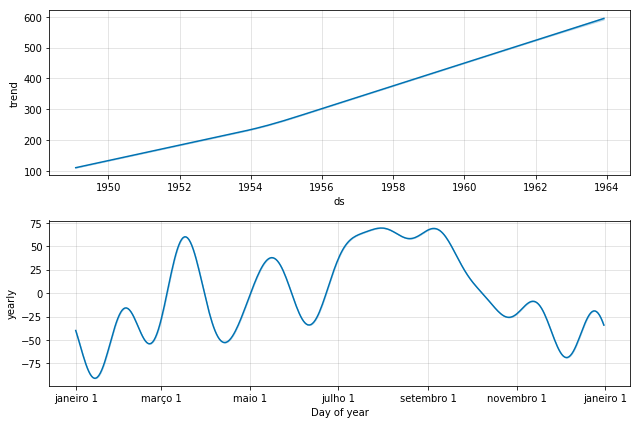

In [56]:
_ = mdl_prophet.plot_components(forecast)

In [104]:
from fbprophet.diagnostics import cross_validation
df_results = cross_validation(mdl_prophet, horizon='720 days')

/home/ispmarin/lib/venvs/ts/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [107]:
df_results.groupby('cutoff').apply(error_measure)

cutoff
1955-02-01     (1755.3362785015586, 33.70171244401064)
1956-01-27    (1151.8740580713616, 23.794993141614274)
1957-01-21       (1455.59874571765, 33.37723870525851)
1958-01-16     (1864.9664314933473, 39.46930340211465)
1959-01-11     (1622.5431445013198, 31.19670783096439)
dtype: object

# R

In [10]:
%%R
library(forecast)
library(ggplot2)

df <- read.csv('../data/passenger.csv')
auto.arima(df)

Series: df 
ARIMA(4,1,2) with drift 

Coefficients:
         ar1     ar2      ar3      ar4      ma1      ma2   drift
      0.2243  0.3689  -0.2567  -0.2391  -0.0971  -0.8519  2.6809
s.e.  0.1047  0.1147   0.0985   0.0919   0.0866   0.0877  0.1711

sigma^2 estimated as 706.3:  log likelihood=-670.07
AIC=1356.15   AICc=1357.22   BIC=1379.85


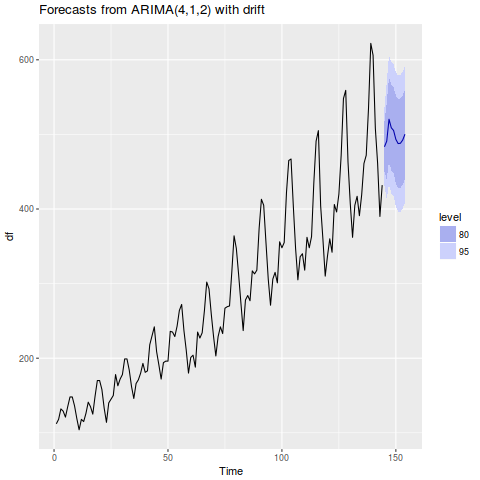

In [16]:
%%R
mdl_r = auto.arima(df)
y_hat = forecast(mdl_r)
autoplot(y_hat)